This code is based on work done by Quang Minh Do and Incheon Paik in their paper: "Resolving Lexical Ambiguity in English–Japanese
Neural Machine Translation." It uses word embeddings generated by a pretrained Japanese BERT model to replace the input word embedding layer in a transformer which is trained on a translation task. The results unfortunately show the model did not train properly. I intend to continue work on this model to figure out what is causing the issues. A link to the write up done on this project in it's current state is in the github repository.


Note: https://arusl.medium.com/japanese-english-language-translation-with-transformer-using-pytorch-243738146806 was heavily used a resource

In [ ]:
#Install libraries
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 33.4 MB/s 
     |████████████████████████████████| 182 kB 76.8 MB/s 
     |████████████████████████████████| 7.6 MB 86.4 MB/s 


In [ ]:
!pip install fugashi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 615 kB 32.8 MB/s 


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 39.6 MB/s 


In [ ]:
!pip install unidic_lite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47.4 MB 1.3 MB/s 
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658837 sha256=e533d441116b9192d12b146a45ddc01f4b9c11a02786925a8ec5dc3d2b9ccf94
  Stored in directory: /root/.cache/pip/wheels/8c/dd/8f/e21fc192dcd38ae31e1185ce4e66e12df4e811e3d469866e15
Successfully built unidic-lite


In [ ]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.6 MB/s 
     |████████████████████████████████| 451 kB 73.2 MB/s 
     |████████████████████████████████| 132 kB 94.7 MB/s 
     |████████████████████████████████| 212 kB 103.1 MB/s 
     |████████████████████████████████| 127 kB 98.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
#Import libraries
import torch
from torch import Tensor
import numpy as np
import torch.nn as nn
from torch.nn import Transformer
import math
from collections import Counter
import torchtext
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import io
import time
import pandas as pd
import numpy as np
import pickle
from datasets import load_dataset
from torchtext.vocab import vocab
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, PreTrainedTokenizer, BertTokenizer
from torch.nn import functional as F
import logging
import sentencepiece
import evaluate
import json
from google.colab import drive
#Mount google drive
drive.mount('/content/gdrive')
logging.basicConfig(level=logging.INFO)

Mounted at /content/gdrive


In [ ]:
#Get to right directory
%cd gdrive/MyDrive/JASS/JASS

/content/gdrive/.shortcut-targets-by-id/15w8Q6Yqlvpw195--z-LB2uXAU2qv8L3-/JASS/JASS


Note: The following cells are not needed once the dataset has been saved as json files and the English tokenizer has been trained

In [ ]:
#Function to read in dataset splits and store them in a dictionary
#dataset_type = string of split name (i.e. train, test)
def generate_dict(dataset_type):
  #Set up dictionary, open and read files
  pair_dict = {}
  en_file_name = dataset_type+'.en'
  jp_file_name = dataset_type+'.ja'
  en_data = open(en_file_name, 'r')
  jp_data = open(jp_file_name, 'r')
  en_sentences = en_data.readlines()
  jp_sentences = jp_data.readlines()
  en_sentences_num = len(en_sentences)
  jp_sentences_num = len(jp_sentences)
  #Match sure number of sentences match
  if en_sentences_num != jp_sentences_num:
    print("File lengths don't match")
    return
  sent_pairs = []
  #Go over sentence pairs and save in as dictionaries in a list
  for i in range(en_sentences_num):
    line_dict = {'en':en_sentences[i].strip(),'ja':jp_sentences[i].strip()}
    sent_pairs.append(line_dict)
  #Add the list of dictionaries to main dictionary
  pair_dict.update({'data':sent_pairs})
  en_data.close()
  jp_data.close()
  return pair_dict

#Function to write a dataset split dictionary as a json file
#file_dict = dictionary holding dataset split
#split = string with split name
def write_json(file_dict, split):
  file_name = split+'.json'
  with open(file_name, "w") as outfile:
    json.dump(file_dict, outfile)

#Function to generate dataset split dictionaries and save them as files
def generate_dataset_json():
  splits = ['test','valid','train']
  for split in splits:
    split_dict = generate_dict(split)
    write_json(split_dict,split)


generate_dataset_json()


In [ ]:
#Dictionary of dataset splits and file names
data_files = {"train": "train.json", "test": "test.json", "valid": "valid.json"}
#Load all the dataset splits
dataset = load_dataset("json", data_files=data_files, field="data")

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-0f621bbd87223aff/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
#Need to create a tokenizer for the English text, this function is used 
#for feeding in the data to train the tokenizer
def get_training_corpus():
    return (
        dataset["train"][i : i + 1000]["en"]
        for i in range(0, len(dataset["train"]), 1000)
    )


training_corpus = get_training_corpus()
#Get a BERT english tokenizer from hugging face
old_en_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", return_tensors = "pt", model_max_length = 512)
#Standard BERT Vocab size
BERT_VOCAB_SIZE = 30522
#Now retrain the tokenizer on the training data for our model
en_tokenizer = old_en_tokenizer.train_new_from_iterator(training_corpus, BERT_VOCAB_SIZE)

In [ ]:
#Save the tokenizer
en_tokenizer.save_pretrained("BERT_ASPEC_En_Tokenizer")

Resume cell running here 

In [ ]:
#Name of japanese bert model
japanese_bert = "cl-tohoku/bert-base-japanese-v2"

In [ ]:
#Load the pretrained japanese BERT model 
jbert = AutoModelForMaskedLM.from_pretrained(japanese_bert)

Downloading:   0%|          | 0.00/517 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Load to device
jbert = jbert.to(device)

In [ ]:
#load the pretrained Japanese BERT tokenizer
ja_tokenizer = AutoTokenizer.from_pretrained(japanese_bert, return_tensors = "pt", model_max_length = 512)

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

In [ ]:
#Load the trained English tokenizer
en_tokenizer = AutoTokenizer.from_pretrained("BERT_ASPEC_En_Tokenizer")

Again the following cells can be skipped if the dataset has been saved as torch objects already

In [ ]:
#Function to generate torch tensors with the tokenized english and Japanese sentences
#ja = Japanese sentences
#en = English sentences
def data_process(ja, en):
  data = []
  for (raw_ja, raw_en) in zip(ja, en):
    ja_tensor_ = torch.tensor(ja_tokenizer(raw_ja, truncation=True)['input_ids'],
                            dtype=torch.long)
    en_tensor_ = torch.tensor(en_tokenizer(raw_en, truncation=True)['input_ids'],
                            dtype=torch.long)
    data.append((ja_tensor_, en_tensor_))
  return data

#Get the training data
train_data = data_process(dataset["train"][:]["ja"], dataset["train"][:]["en"])

In [ ]:
#Validation and test data
valid_data = data_process(dataset["valid"][:]["ja"], dataset["valid"][:]["en"])
test_data = data_process(dataset["test"][:]["ja"], dataset["test"][:]["en"])

In [ ]:
#Save the data as tensors so the processing doesn't need to be done again
torch.save(train_data,'tensor_train_data.pt')
torch.save(valid_data,'tensor_valid_data.pt')
torch.save(test_data,'tensor_test_data.pt')

Resume cell running here

In [ ]:
#Load the datasets
train_data = torch.load('tensor_train_data.pt')
valid_data = torch.load('tensor_valid_data.pt')
test_data = torch.load('tensor_test_data.pt')

In [ ]:
#Get the vocab sizes
ja_tokenizer_vocab = ja_tokenizer.get_vocab()
en_tokenizer_vocab = en_tokenizer.get_vocab()

In [ ]:
#Some constants
BATCH_SIZE = 32
CLS_IDX = ja_tokenizer_vocab['[CLS]']
MASK_IDX = ja_tokenizer_vocab['[MASK]']
PAD_IDX = ja_tokenizer_vocab['[PAD]']
SEP_IDX = ja_tokenizer_vocab['[SEP]']
UNK_IDX = ja_tokenizer_vocab['[UNK]']

#Function to generate batchs of data during training
def generate_batch(data_batch):
  ja_batch, en_batch = [], []
  #Get the data
  for (ja_item, en_item) in data_batch:
    ja_batch.append(ja_item)
    en_batch.append(en_item)
  #Add padding
  ja_batch = pad_sequence(ja_batch, padding_value=PAD_IDX)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  return ja_batch, en_batch

#Get the training and validation data into data iterators 
train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)

In [ ]:
#Import more libraries
from torch.nn import (TransformerEncoder, TransformerDecoder,
                      TransformerEncoderLayer, TransformerDecoderLayer)

#Define standard seq to seq transformer, will train one as a baseline if time permits
class Seq2SeqTransformer(nn.Module):
    #Constructor
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int,
                 emb_size: int, src_vocab_size: int, tgt_vocab_size: int,
                 dim_feedforward:int = 512, dropout:float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        decoder_layer = TransformerDecoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    #function for a forward run through the network
    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor,
                tgt_mask: Tensor, src_padding_mask: Tensor,
                tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
                                        tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    #Encode input
    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)
    #Decode input
    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer_decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

#BERT Seq to Seq Transformer
class BERTSeq2SeqTransformer(nn.Module):
    #Constructor
    #jp_bert = Japanese BERT model
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 jp_bert: AutoModelForMaskedLM,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(BERTSeq2SeqTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        decoder_layer = TransformerDecoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        self.jbert = jp_bert

    #output is the MaskedLMOutput of a Japanese pretrained bert loaded in a AutoModelForMaskedLM
    #model with the output_hidden_states=True flag set to true, i.e. 
    #japanese_bert_model(**tokenized_input,output_hidden_states=True)
    #Will return a torch tensor with the CLS sentence embeddings for the outputs of size [768, batch_length]
    def get_embeddings(self, output):
      hidden = output.hidden_states
      #concatenate the hidden states into one tensor of size [13, sequence_length, batch_length, 768]
      token_embeddings = torch.stack(hidden, dim=0)
      #Now average all token embeddings from the last 10 layers to get the sentence embedding
      cls_sent_emb = torch.mean(token_embeddings[-10:,:,:,:],0)
      return cls_sent_emb

    #function for a forward run through the network
    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):

        #Pass input to BERT to get network outputs
        outputs = self.jbert(src,output_hidden_states=True)
        #Get the embeddings and add positional encodings
        src_emb = self.positional_encoding(self.get_embeddings(outputs))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
                                        tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    #Encode input
    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    #Decode input
    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer_decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
#Positional encoding class, used to generate positional encodings
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding +
                            self.pos_embedding[:token_embedding.size(0),:])

#Token embedding class, the embedding layer for the transformer
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [ ]:
#Function to generate square subsequent mask, used for decoding
#size = target seq length
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

#Function to generate source/target masks and padding masks
#src = source sequence
#tgt = target sequence
def create_mask(src, tgt):
  src_seq_len = src.shape[0]
  tgt_seq_len = tgt.shape[0]
  
  tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
  src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

  src_padding_mask = (src == PAD_IDX).transpose(0, 1)
  tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)

  return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
#Connect torch to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Some more constants and model/training hyperparameters
SRC_VOCAB_SIZE = ja_tokenizer.vocab_size
TGT_VOCAB_SIZE = en_tokenizer.vocab_size
EMB_SIZE = 768
NHEAD = 8
FFN_HID_DIM = 3072
BATCH_SIZE = 32
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6
NUM_EPOCHS = 30
#Loss fucntion
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
#Function to run a training epoch
#model = transformer model
#train_iter = training dataset iterator
#optimizer = torch optimizer
def train_epoch(model, train_iter, optimizer):
  #Set model to train
  model.train()
  losses = 0
  
  #Go over dataset
  for idx, (src, tgt) in enumerate(train_iter):
      #Get data on device
      src = src.to(device)
      tgt = tgt.to(device)

      tgt_input = tgt[:-1, :]

      #Generate masks
      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

      #Get logits
      logits = model(src, tgt_input, src_mask, tgt_mask,
                                src_padding_mask, tgt_padding_mask, src_padding_mask)
      optimizer.zero_grad()

      tgt_out = tgt[1:,:]
      #Get loss
      loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
      #Backprop
      loss.backward()
      #Step optimizer
      optimizer.step()
      #Add loss
      losses += loss.item()
  #Return average loss
  return losses / len(train_iter)

#Function to evaluate model on dataset
#model = transformer model
#val_iter = validation dataset iterator
def evaluate(model, val_iter):
  #Set model to eval model
  model.eval()
  losses = 0

  #Go over dataset
  for idx, (src, tgt) in (enumerate(valid_iter)):
    #Get data on device
    src = src.to(device)
    tgt = tgt.to(device)

    tgt_input = tgt[:-1, :]

    #Generate masks
    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

    #Get logits
    logits = model(src, tgt_input, src_mask, tgt_mask,
                              src_padding_mask, tgt_padding_mask, src_padding_mask)
    tgt_out = tgt[1:,:]
    #Get loss and add to total
    loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    losses += loss.item()
  #Return average loss
  return losses / len(val_iter)


In [ ]:
#Function to save the training and validation losses over the training epochs
#train_losses = list of training losses
#val_losses = list of validation losses
def save_losses(train_losses, val_losses):
  #File names
  train_loss_file = 'train_loss.txt'
  val_loss_file = 'val_loss.txt'
  #Write the lists to their files
  with open(train_loss_file,'w') as file:
    for train_loss in train_losses:
      file.write(str(train_loss)+'\n')
  with open(val_loss_file,'w') as file:
    for val_loss in val_losses:
      file.write(str(val_loss)+'\n')

In [ ]:
#function to load the training and validation losses from the files. But
#since training on saves the model every other epoch, epoch is taken as a argument
#to not include the loss for an epoch that was not saved. This is needed since training
#will likely need to be restarted
#epoch = epoch to load losses up to
def load_losses(epoch):
  #File names
  train_loss_file = 'train_loss.txt'
  val_loss_file = 'val_loss.txt'
  #Lists for losses
  train_losses, val_losses = [], []
  #load the losses and save in lists
  with open(train_loss_file,'r') as file:
    lines = file.readlines()
    for line in lines:
      train_losses.append(float(line.strip()))
  with open(val_loss_file,'r') as file:
    lines = file.readlines()
    for line in lines:
      val_losses.append(float(line.strip()))
  #It's possible the losses have an epoch that wasn't checkpointed, so make sure the
  #lists only include the losses up to the epoch checkpoint that was loaded
  train_losses, val_losses = train_losses[:epoch], val_losses[:epoch]
  return train_losses, val_losses

In [ ]:
#List of all possible model checkpoints, with the most recent first
paths = ['checkpoints/model'+str(i)+'.pt' for i in range(NUM_EPOCHS,0,-1) if i%2==0 or i==1]
print()
#Starting epoch
epoch = 1
#Model
transformer = BERTSeq2SeqTransformer(num_encoder_layers=NUM_ENCODER_LAYERS, num_decoder_layers=NUM_DECODER_LAYERS,
                                emb_size=EMB_SIZE, nhead=NHEAD, src_vocab_size=SRC_VOCAB_SIZE, tgt_vocab_size=TGT_VOCAB_SIZE,
                                jp_bert = jbert, dim_feedforward=FFN_HID_DIM)
#Set up optimizer
optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-93
)

#Loop over the possible checkpoint paths starting from the most recent, if the model checkpoint is found start training from there
for path in paths:
  try:
    #Load the checkpoint dictionary
    checkpoint = torch.load(path)
    #Load the model state dictionary into the model
    transformer.load_state_dict(checkpoint['model_state_dict'])
    #Load the optimizer state dictionary into the optimizer
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #adding 1 becuase the increment to epoch happens after saving the model
    #ex: save model after epoch 8, want the training loop to start epoch 9 next
    epoch = checkpoint['epoch']+1
    #Load model onto GPU
    transformer = transformer.to(device)
    #Print which model is checkpoint is loaded
    print("model at: ",path," found and loaded")
    break
  #If a checkpoint is not found print a message
  except:
    print("No model checkpoint found")

#Load model onto GPU
transformer = transformer.to(device)
#Load losses
train_losses, val_losses = load_losses(epoch)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)


No model checkpoint found
No model checkpoint found
No model checkpoint found
No model checkpoint found
No model checkpoint found
No model checkpoint found
model at:  checkpoints/model18.pt  found and loaded


In [ ]:
#Loop over epochs and train
while epoch <= NUM_EPOCHS:
  #Trach epoch training time
  start_time = time.time()
  #Train for an epoch
  train_loss = train_epoch(transformer, train_iter, optimizer)
  #Add train loss to list
  train_losses.append(train_loss)
  end_time = time.time()
  #Print epoch train loss and epoch time
  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "
          f"Epoch time = {(end_time - start_time):.3f}s"))
  #Get the val set loss
  val_loss = evaluate(transformer, valid_iter)
  #Add val loss to list
  val_losses.append(val_loss)
  #Print epoch train loss and epoch time
  print((f"Epoch: {epoch}, val loss: {val_loss:.3f}, "
          f"Epoch time = {(end_time - start_time):.3f}s"))
  #Save the losses to file
  save_losses(train_losses, val_losses)
  #If it is the first epoch or an even number epoch save a checkpoint
  if epoch == 1 or epoch % 2 == 0:
    path = 'checkpoints/model'+str(epoch)+'.pt'
    torch.save({
              'epoch': epoch,
              'model_state_dict': transformer.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'train_loss': train_loss,
              'val_loss': val_loss,
              }, path)
  epoch += 1

In [ ]:
#Greedy decoding function
#model = transformer model
#src = source sequence
#src_mask = = source mask
#max_len = max number of tokens
#start_symbol = sequence start token
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    #Load to device
    src = src.to(device)
    src_mask = src_mask.to(device)
    #Encode
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    #Generate decoded target sequence
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()
        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == SEP_IDX:
          break
    return ys

#Translate function to translate a sentence
#model = transformer model
#src = source sequence
#src_tokenizer = source tokenizer
#tgt_tokenizer = target tokenizer
def translate(model, src,src_tokenizer,tgt_tokenizer):
    #Set model to eval mode
    model.eval()
    #Tokenize source sentence
    tokens = src_tokenizer(src, truncation=True)['input_ids']
    num_tokens = len(tokens)
    #Convert tokens to torch tensor
    src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
    #Get source mask
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    #Get target tokens
    tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=CLS_IDX).flatten()
    #return the translated sentence from the tokens 
    return tgt_tokenizer.decode(tgt_tokens,skip_special_tokens = True)

In [ ]:
#Import bleu score module
from torchtext.data.metrics import bleu_score
#Function to calculate the BLEU score on the test dataset
#data = test data (list of torch tuples with the sentence token ids)
#model = transformer model
#src_tokenizer = source tokenizer
#tgt_tokenizer = target tokenizer
def calculate_BLEU(data, model, src_tokenizer, tgt_tokenizer):
  #Lists for holding tokenized translations and true target sentences
  tokenized_src_pred = []
  tokenized_tgt = []
  #Get tokenized target sentences and tokenized translated source sentences
  for pairs in data:
    #Append tokenized true target sentence to list
    tokenized_tgt.append(tgt_tokenizer.tokenize(tgt_tokenizer.decode(pairs[1],skip_special_tokens=True)))
    #Get the source sentence from the tokens
    src_sent = src_tokenizer.decode(pairs[0],skip_special_tokens=True)
    #Get the predicted translation
    src_pred = translate(model,src_sent,src_tokenizer,tgt_tokenizer)
    #Append tokenized translation sentence to list
    tokenized_src_pred.append(tgt_tokenizer.tokenize(src_pred))
  #Return the BLEU score
  return bleu_score(tokenized_src_pred,tokenized_tgt)

#Get the test BLEU Score and print it
test_blue = calculate_BLEU(test_data, transformer, ja_tokenizer, en_tokenizer)
print("BLEU Score on test data: ", str(test_blue))

BLEU Score on test data:  0.0


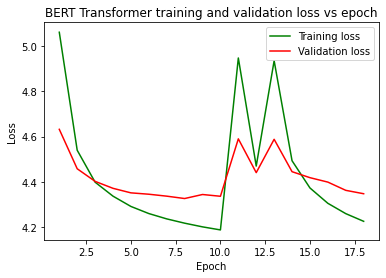

In [ ]:
#Import plotting library
import matplotlib.pyplot as plt
#Function to read all training and validation losses during training from files 
def read_losses():
  #File names
  train_loss_file = 'train_loss.txt'
  val_loss_file = 'val_loss.txt'
  #lists for losses
  train_losses, val_losses = [],[]
  #Read files and store losses in right lists
  with open(train_loss_file,'r') as file:
    lines = file.readlines()
    for line in lines:
      train_losses.append(float(line.strip()))
  with open(val_loss_file,'r') as file:
    lines = file.readlines()
    for line in lines:
      val_losses.append(float(line.strip()))
  return train_losses, val_losses

#All training and validation losses
training_losses, valid_losses = read_losses()

#Function to plot the training and validation losses
#train_losses = list of training losses
#val_losses = list of validation losses
def plot_train_val_loss(train_losses, val_losses):
  #Set up epochs for x axis
  epochs = [int(i+1) for i in range(len(train_losses))]
  #Plot the training and validation losses
  plt.plot(epochs,train_losses, c='green', label = 'Training loss')
  plt.plot(epochs,val_losses, c='red', label = 'Validation loss')
  #Add labels/title
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.title("BERT Transformer training and validation loss vs epoch")
  plt.legend(loc='best')
  plt.show()

plot_train_val_loss(training_losses, valid_losses)

In [ ]:
#Example sentences to translate
sentences = ["私の名前は田中です。","バナナが好きです。","大学で物理学を勉強している。"]
for sentence in sentences:
  print("Original: ", sentence)
  src_pred = translate(transformer,sentence,ja_tokenizer, en_tokenizer)
  print("Translation: ", src_pred)

Original:  私の名前は田中です。
Translation:  The case was a 66 - year - old woman.
Original:  バナナが好きです。
Translation:  The case was a 66 - year - old woman.
Original:  大学で物理学を勉強している。
Translation:  The patient was discharged from the hospital on day 14.
